In [26]:
%load_ext autoreload
%autoreload 2

import os
import random
from abc import abstractmethod
from os.path import join as oj
from tqdm import tqdm
from typing import Dict

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Memory
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz, export_text

from rulevetting.projects.tbi_pecarn.dataset import Dataset
from rulevetting.api import validation
from rulevetting.projects.tbi_pecarn import helper
from rulevetting.projects.tbi_pecarn import graph

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
# loading in the data - edit below path
data_path = '/Users/marko/rule-vetting/data'
df = Dataset().clean_data(data_path = data_path)

Reading the raw CSVs... ['TBI PUD 10-08-2013.csv', 'TBI PUD Imaging.csv', 'TBI PUD Neuro.csv']


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.45it/s]


Here we try to replicate the model in the paper by first trying to mirror how the paper cleaned the data. 

Checking if the dataset has the same length - 43,399 evaluable patients.

In [28]:
len(df)

43399

Removing GCSTotal scores that are not 14 or 15. There should be 969 with GCS 3-13 and 18 that are missing the outcome variable. However, we find 20 

In [29]:
# printing the number of GCSTotal scores that are misssing
num_missing = len(df[df['PosIntFinal'] == 'Unknown'])
print(f'There are {num_missing} missing the primary outcome: PosIntFinal.\n')

# printing the number of GCSTotal scores that are less than 14
num_low_gcs = len(df[df['GCSTotal'] < 14])
print(f'There are {num_low_gcs} GCSTotal scores less than 14.')

There are 20 missing the primary outcome: PosIntFinal.

There are 969 GCSTotal scores less than 14.


To match the same processing of the paper, I decide to remove the 20 missing primary outcomes (despite not matching the 18 referenced in the paper) and the 969 patients with low GCSTotal scores.

In [30]:
df = df[df['PosIntFinal'] != 'Unknown']
df = df[df['GCSTotal'] >= 14]

# remove also post ct variables here
df = df.drop(columns=Dataset().get_post_ct_names())

Now to continue with the paper's modeling, I impute the unknowns/NaNs with the most common responses and then make the variable transformations outlined in the paper. 

In [31]:
def impute_unknowns(cleaned_data):
    # judgement call: since sfxpalp are all yes with sfxpalpdepress == unknown and distribution of ciTBI is much higher
    cleaned_data.loc[cleaned_data['SFxPalpDepress'] == 'Unknown', 'SFxPalpDepress'] = 'Yes'
    
    # Impute unknowns with most common if not specified in documentation
    for col in cleaned_data.columns.tolist():
        cleaned_data.loc[cleaned_data[col] == 'Unknown', col] = cleaned_data.mode()[col][0]
        
    # Impute the ones that have descriptions about dealing with not applicables
    not_applicable_doc_feats = ['SeizOccur', 'VomitNbr', 'VomitStart', 'VomitLast', 'AMSAgitated', 'AMSSleep',
                                'AMSSlow', 'AMSRepeat', 'AMSOth', 'SFxBasHem', 'SFxBasOto', 'SFxBasPer', 
                               'SFxBasRet', 'SFxBasRhi', 'ClavFace', 'ClavNeck', 'ClavFro', 'ClavOcc', 
                               'ClavPar', 'ClavTem', 'NeuroD', 'NeuroDMotor', 'NeuroDSensory', 'NeuroDCranial',
                                'NeuroDReflex', 'NeuroDOth', 'OSIExtremity', 'OSICut', 'OSICspine', 'OSIFlank',
                                'OSIAbdomen', 'OSIPelvis', 'OSIOth']
    for col in  not_applicable_doc_feats:
        cleaned_data.loc[cleaned_data[col] == 'Not applicable', col] = 'No'
    
    return cleaned_data

df = impute_unknowns(df)

# now we make the same transformations mentioned in the paper
df['HemaBinary'] = [1 if hematype in ['Parietal/Temporal', 'Occipital'] else 0 for hematype in df['HemaLoc'].tolist()]
df['LocBinary'] = [1 if loc_len in ['5 sec - 1 min', '1-5 min', '>5 min'] else 0 for loc_len in df['LocLen'].tolist()]
df['MechBinary'] = [1 if inj_sev in ['High'] else 0 for inj_sev in df['High_impact_InjSev'].tolist()]
df['HABinary'] = [1 if ha_sev in ['Severe'] else 0 for ha_sev in df['HASeverity'].tolist()]
df['SeizLen'] = [1 if seiz_len in ['>15 min', '5-15 min', '1-5 min'] else 0 for seiz_len in df['SeizLen'].tolist()]
df['HemaSizeBinary'] = [1 if hema_size in ['Medium', 'Large'] else 0 for hema_size in df['HemaSize'].tolist()]
df['LocSeparateBinary'] = [1 if loc_hist in ['Suspected', 'Yes'] else 0 for loc_hist in df['LOCSeparate'].tolist()]
df['SFxPalpBinary'] = [1 if sfx_palp in ['Yes', 'Unclear'] else 0 for sfx_palp in df['SFxPalp'].tolist()]

# dropping the ones we binarized
df = df.drop(columns=['HemaLoc', 'LocLen', 'High_impact_InjSev', 'HASeverity', 'SeizLen', 'HemaSize', 'LOCSeparate',
                      'SFxPalp'], errors='ignore')

# remapping binary + 92 (not applicable) variables
bool_cols = [col for col in df if np.isin(df[col].unique(), ['No', 'Yes']).all()]
for bool_col in bool_cols:
    df[bool_col] = df[bool_col].map({'No': 0, 'Yes': 1})

/Users/marko/rule-env/lib/python3.9/site-packages/numpy/lib/arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Now we drop the columns AgeInMonth, AgeinYears, Ethnicity, Race, Gender, id, EmplType, and Certification. 

In [33]:
irrelevant_vars = ['AgeInMonth', 'AgeinYears', 'Ethnicity', 'Race', 'Gender', 'id', 'EmplType',
                   'Certification', 'GCSEye', 'GCSVerbal']
df = df.drop(columns=irrelevant_vars, errors='ignore')

Now we one-hot encode the remaining categorical variables.

In [34]:
df = helper.one_hot_encode_df(df)

Here we take a gander at the head of the dataframe - looks good.

In [35]:
df.head()

,Seiz,ActNorm,Vomit,Dizzy,Intubated,Paralyzed,Sedated,GCSTotal,GCSGroup,AMS,...,VomitLast_1-4 hrs before ED,VomitLast_<1 hr before ED,VomitLast_>4 hrs before ED,VomitLast_No,GCSMotor_Follow commands,GCSMotor_Localizes pain,GCSMotor_Pain withdraws,SFxPalpDepress_No,SFxPalpDepress_Not applicable,SFxPalpDepress_Yes
0,0,1,0,0,0,0,0,15,2,0,...,0,0,0,1,1,0,0,0,1,0
1,0,1,1,0,0,0,0,15,2,0,...,0,1,0,0,1,0,0,0,1,0
3,0,1,0,0,0,0,0,15,2,0,...,0,0,0,1,1,0,0,0,1,0
5,0,1,0,0,0,0,0,15,2,0,...,0,0,0,1,1,0,0,0,1,0
6,0,1,1,0,0,0,0,15,2,1,...,0,0,1,0,1,0,0,0,1,0


Now, the cleaning is done for the baseline model. From here, I simply try fitting the model described in the paper. However first, I split the data into two separate trees to estimate - one for kids less than two and one for kids more than two years old.

In [36]:
# constructing the young dataframe 
young_feats = ['AMS', 'HemaBinary', 'LocBinary', 'MechBinary', 'SFxPalpBinary', 'ActNorm']
df_young = df[df['AgeTwoPlus'] == 1].drop(columns=['AgeTwoPlus'], errors='ignore')
df_young = df_young[young_feats + ['PosIntFinal']]

# constructing the old dataframe
old_feats = ['AMS', 'LocSeparateBinary', 'Vomit', 'MechBinary', 'SFxPalpBinary', 'HABinary']
df_old = df[df['AgeTwoPlus'] == 2].drop(columns=['AgeTwoPlus'], errors='ignore')
df_old = df_old[old_feats + ['PosIntFinal']]

Now, we can split the data and test out the decision tree.

In [37]:
df_young_train, df_young_test, _ = Dataset().split_data(df_young)
df_old_train, df_old_test, _ = Dataset().split_data(df_old)

Now that we've split the data into relatively similar splits to what is referenced in the paper, we can try to develop a similar decision rule to the one mentioned. Specifically, they say they use "binary recurisve partitioning with ten-fold cross validation and standard Gini splitting rules alongside a relative cost of 500 to 1 for failure to identify a patient with ciTBI versus incorrect classification of a patient without ciTBI". I assume that they desire to minimize the false negatives by assigning a higher cost to positive outcomes and so in sklearn we would implement this by choosing the class_weights to be 500 for ciTBI and 1 for no ciTBI. However, this results in scores which are not comparable to the paper and so I decide to leave equal weighting for the two classes.

100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 1354.62it/s]


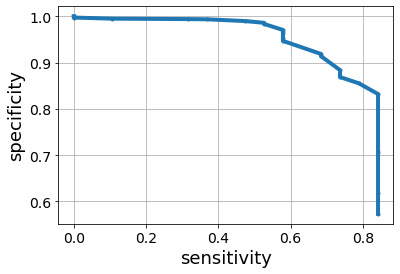

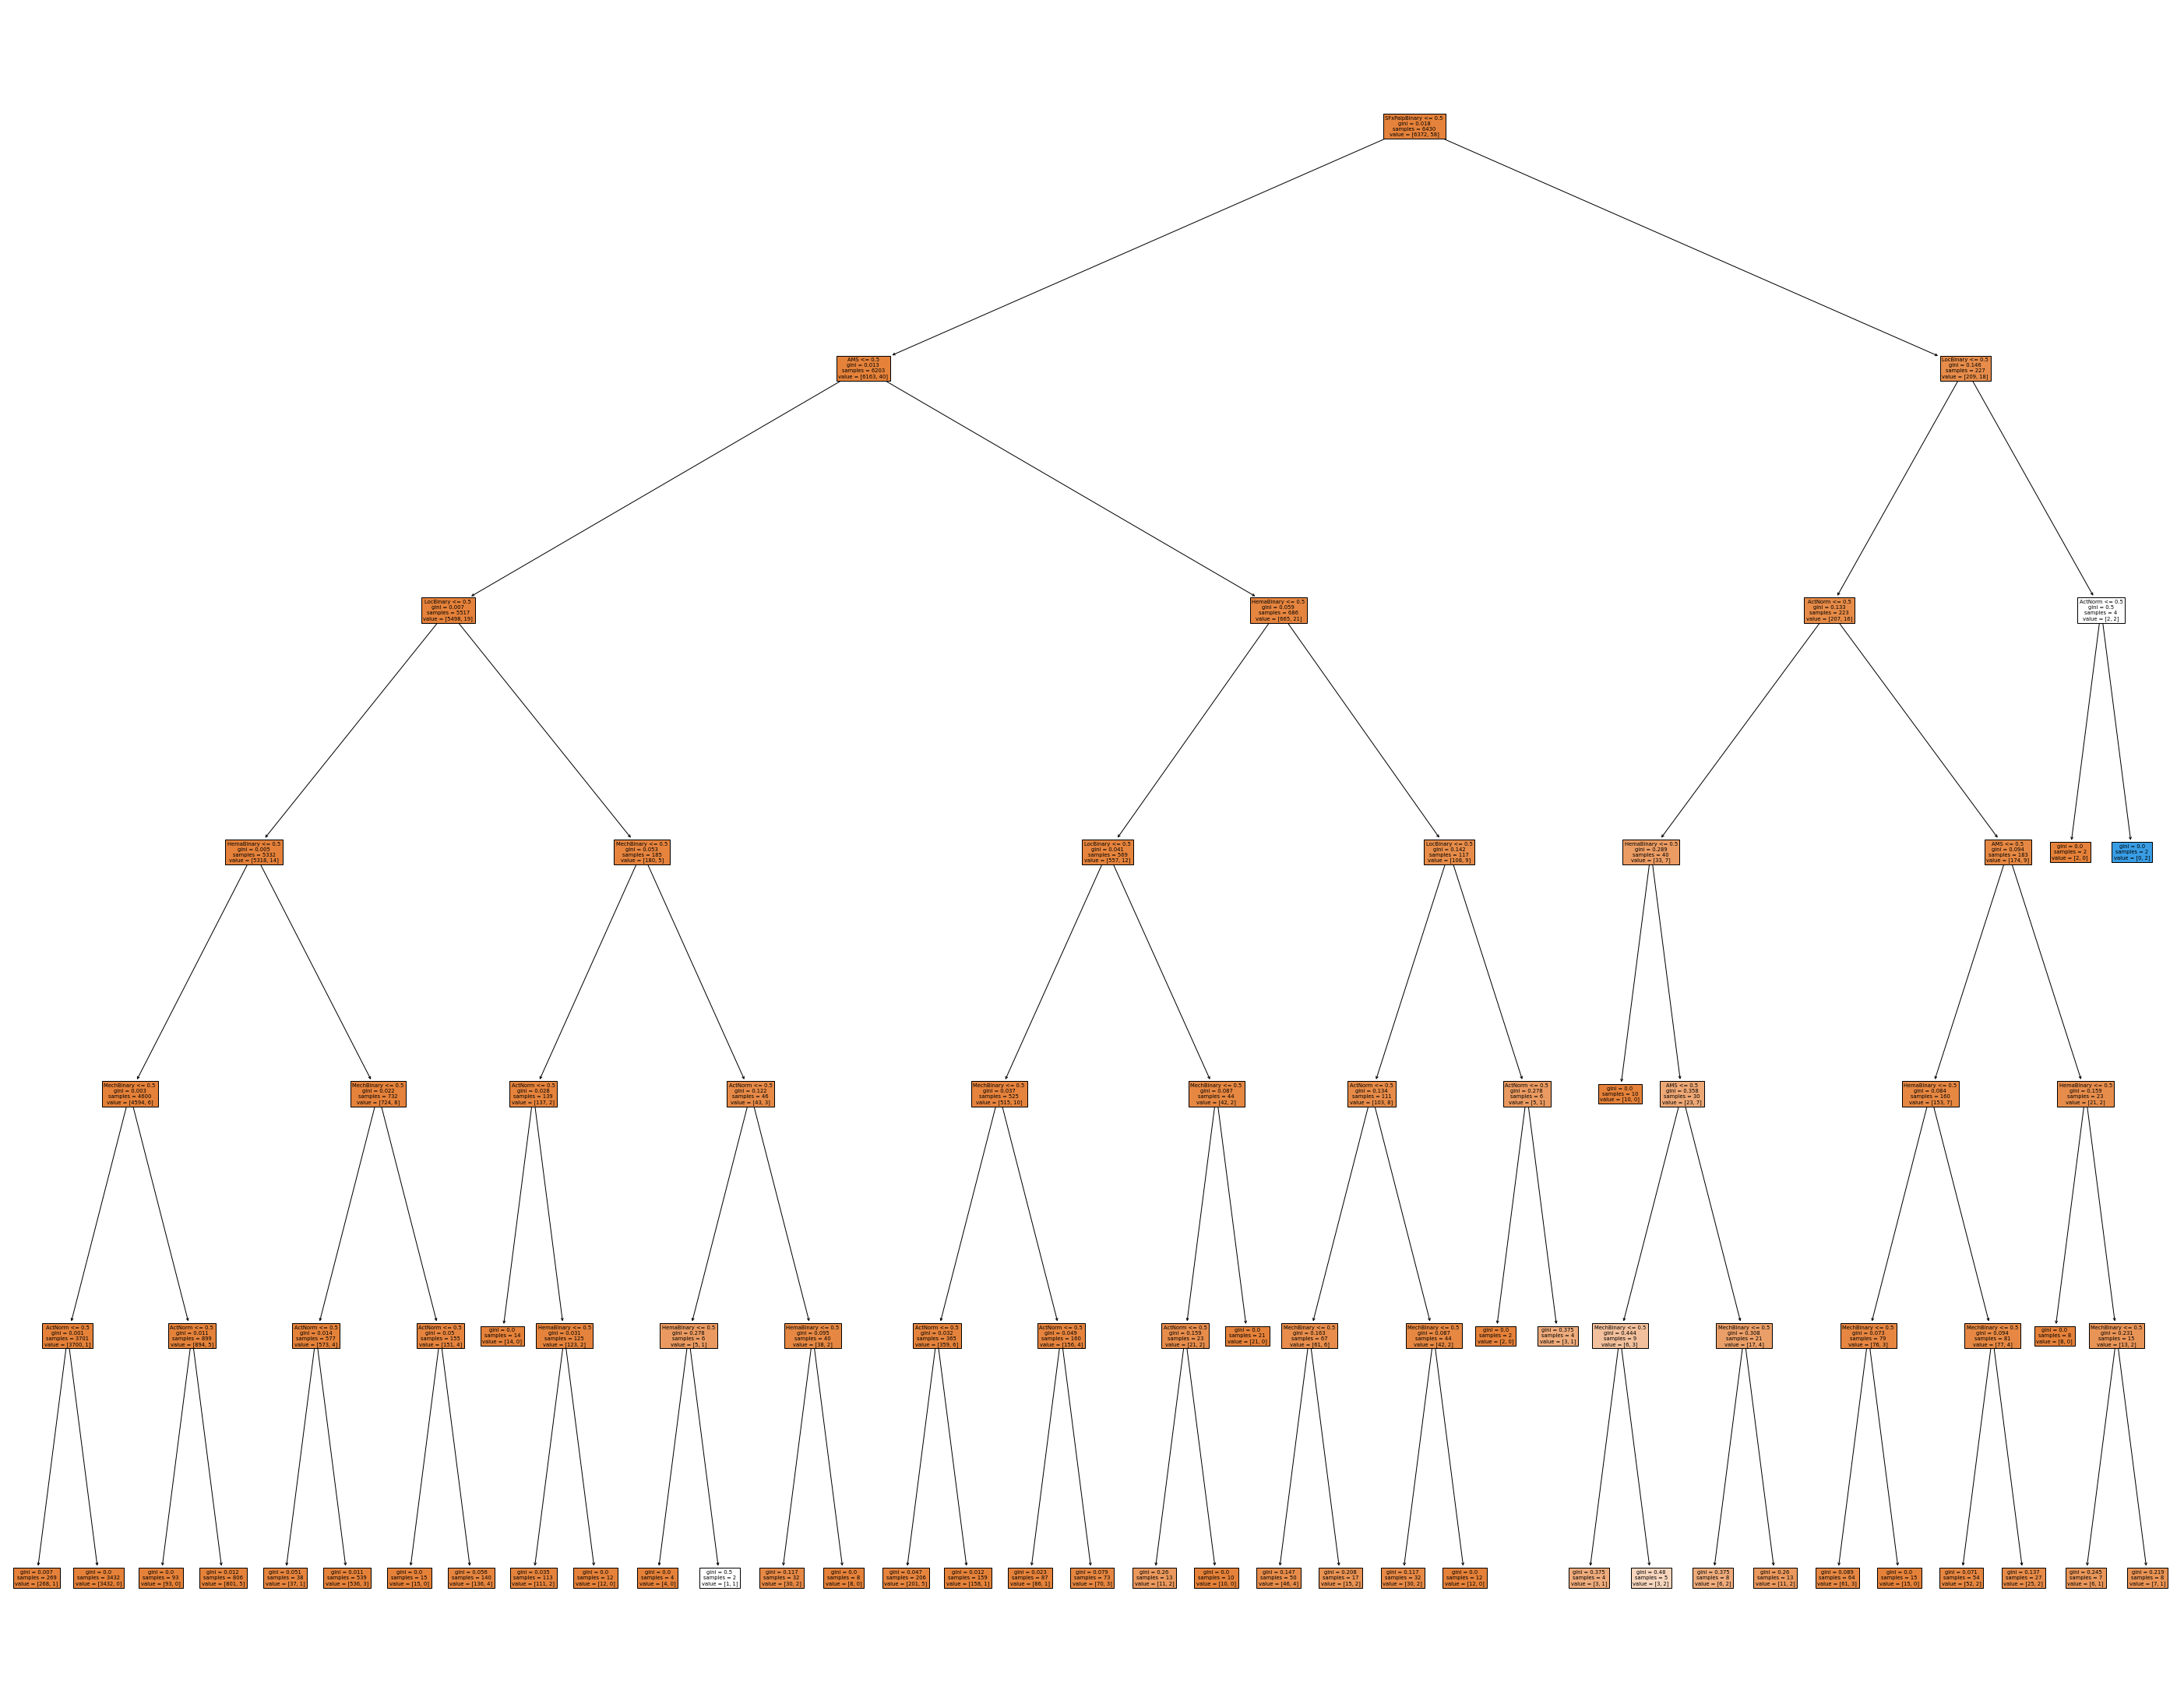

Feature Importances:

ActNorm        0.310
HemaBinary     0.195
SFxPalpBinary     0.184
LocBinary      0.143
AMS            0.098
MechBinary     0.070

Test Score:

0.9911380597014925


In [38]:
# looking at the young decision tree - first with equal weights and same depth
outcome_def = 'PosIntFinal'
X_train = df_young_train.drop(columns=outcome_def)
y_train = df_young_train[outcome_def].values
X_tune = df_young_test.drop(columns=outcome_def)
y_tune = df_young_test[outcome_def].values
feature_names = list(X_train)

def predict_and_save(model, model_name='decision_tree'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_tune],
                            [y_train, y_tune],
                            ['_train', '_tune']):
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x)[:, 1],
                                                     plot=suffix == '_tune')
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
    return stats, threshes

# fitting the model 
dt = DecisionTreeClassifier(max_depth=6, class_weight={0: 1, 1: 1})
dt.fit(X_train, y_train)
stats, threshes = predict_and_save(dt, model_name='decision_tree')
plt.show()

fig = plt.figure(figsize=(50, 40))
plot_tree(dt, feature_names=feature_names, filled=True)
plt.show()

print('Feature Importances:\n')
for col, val in sorted(zip(X_train.columns, dt.feature_importances_), key=lambda x: x[1], reverse=True)[:10]:
    print(f'{col:10}{val:10.3f}')
    
print('\nTest Score:\n')
print(dt.score(X_tune, y_tune))

And now for the patients older than two.

100%|█████████████████████████████████████████| 32/32 [00:00<00:00, 1063.62it/s]


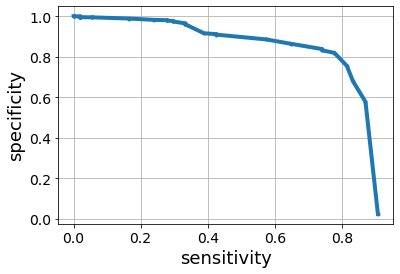

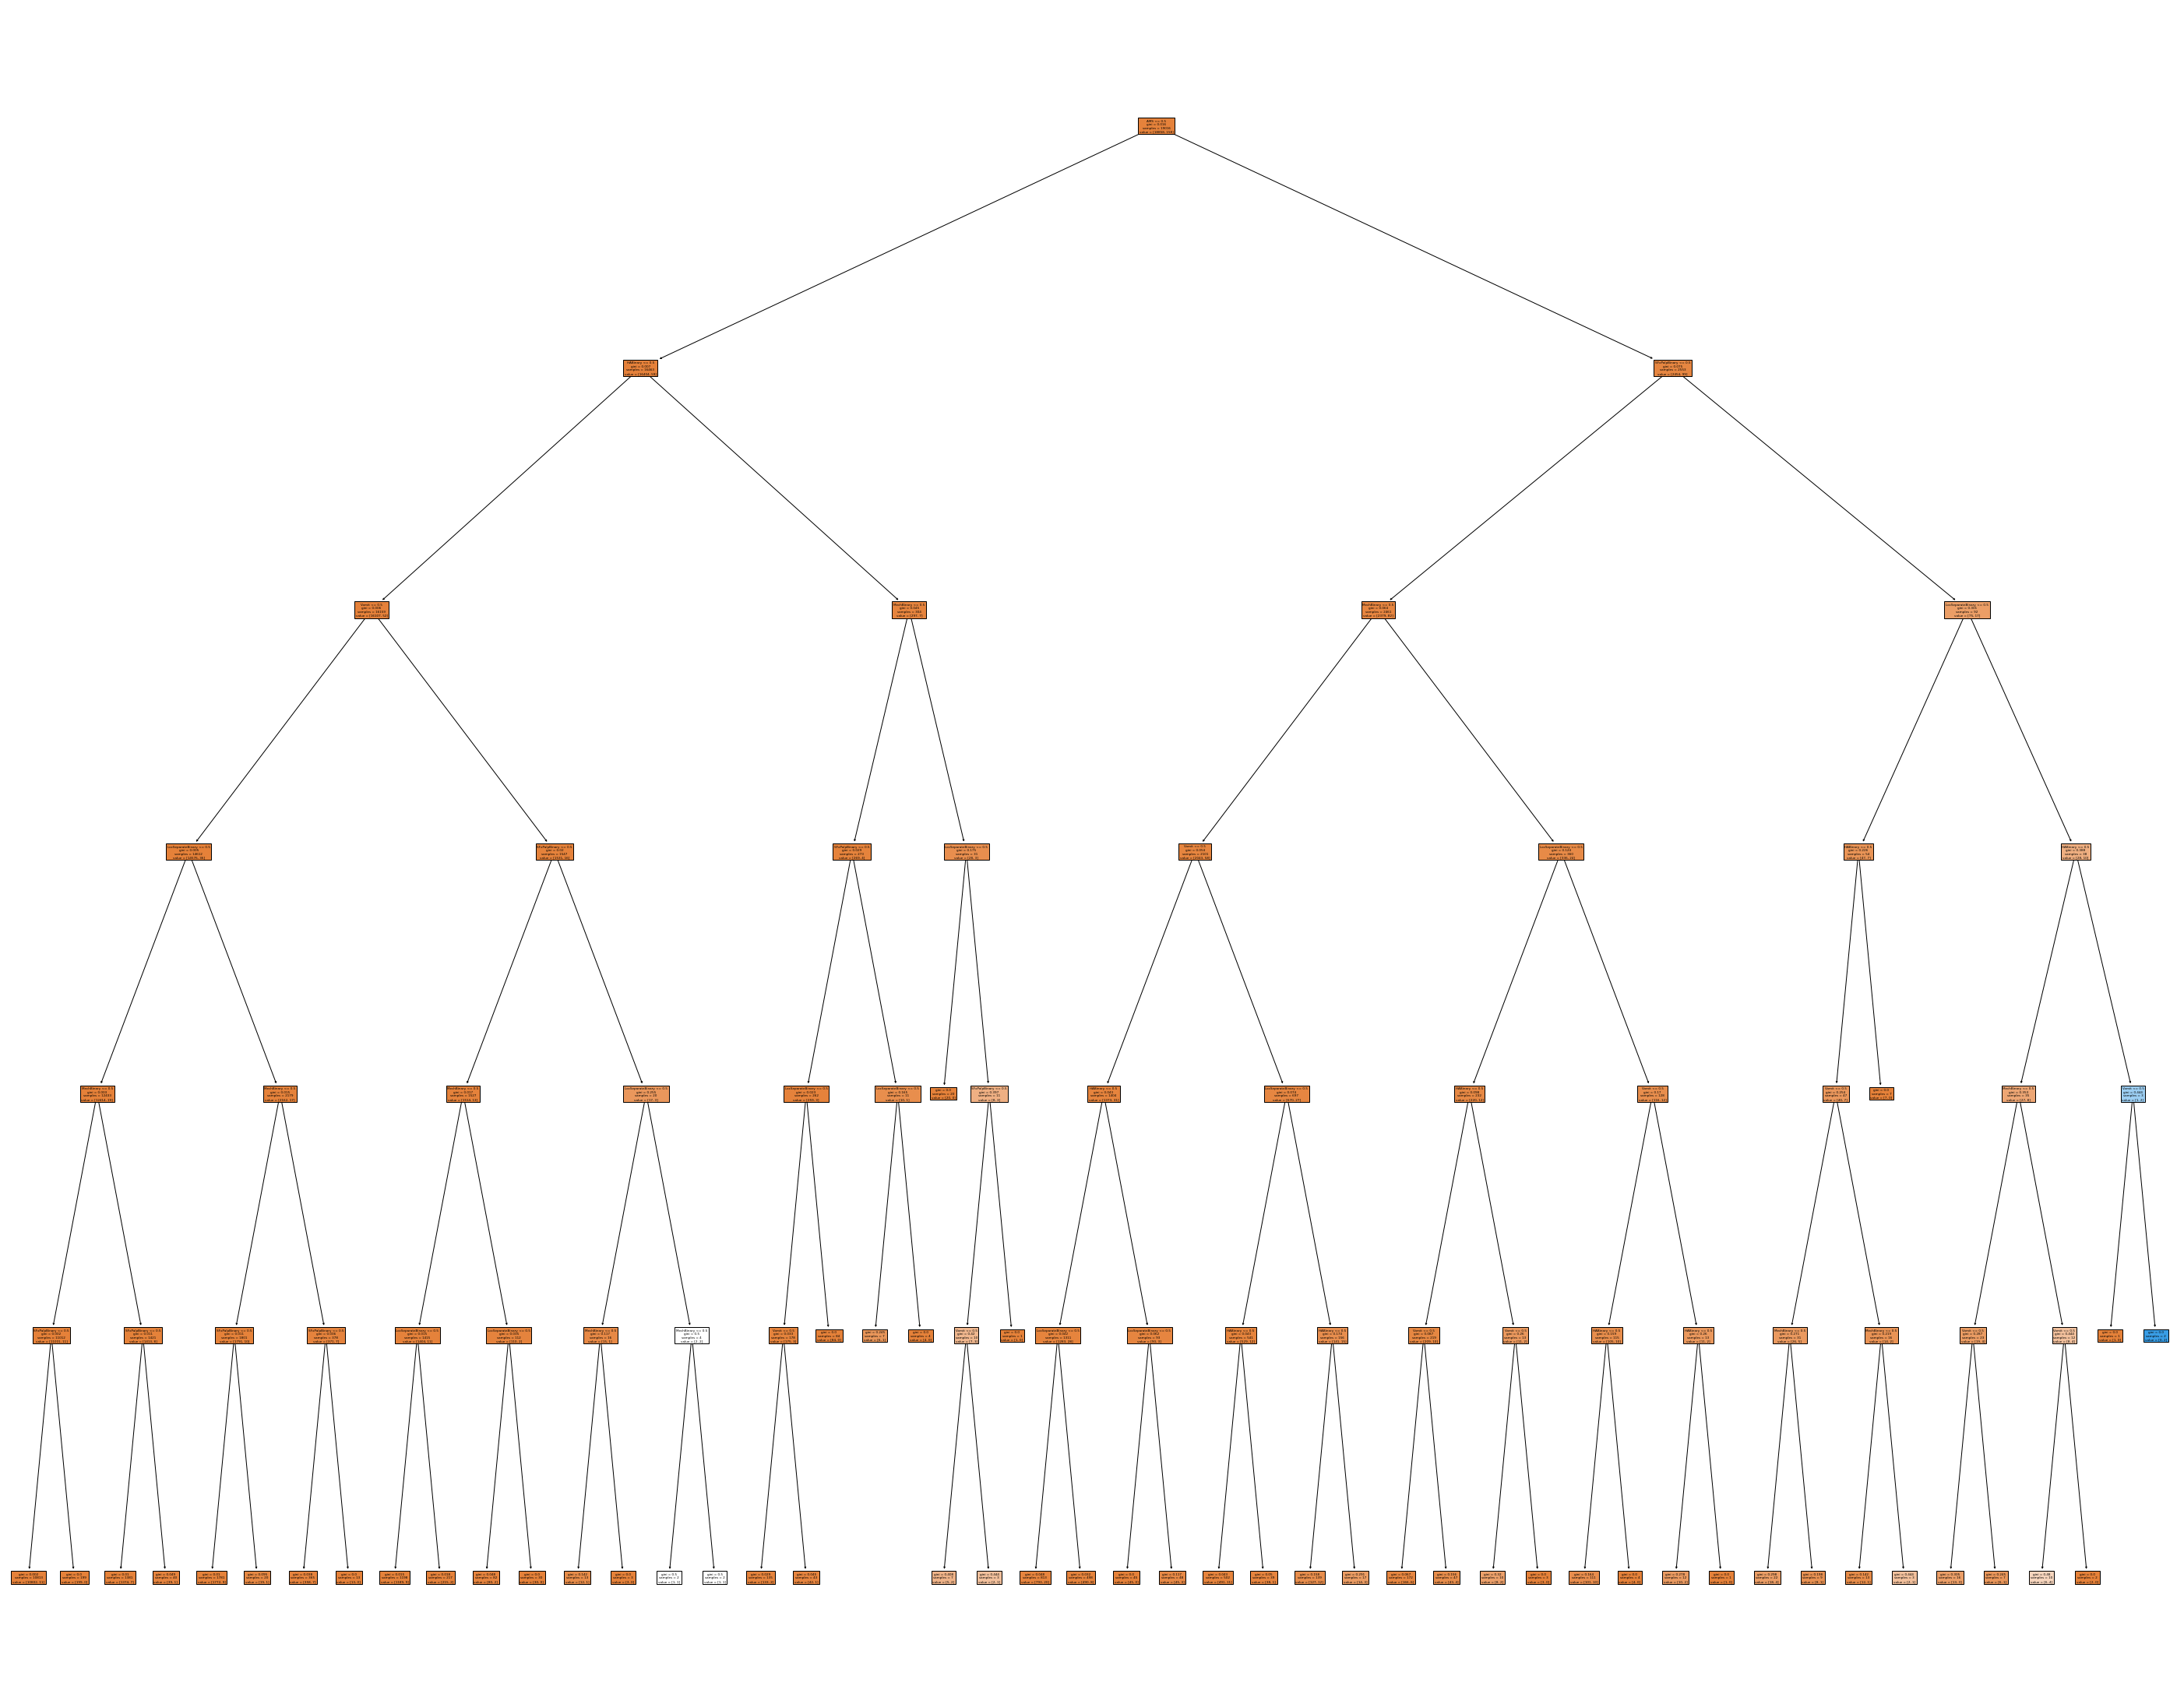

Feature Importances:

AMS            0.234
SFxPalpBinary     0.226
LocSeparateBinary     0.224
Vomit          0.121
MechBinary     0.099
HABinary       0.096

Test Score:

0.9914813061997161


In [39]:
# looking at the old decision tree - first with equal weights and same depth
outcome_def = 'PosIntFinal'
X_train = df_old_train.drop(columns=outcome_def)
y_train = df_old_train[outcome_def].values
X_tune = df_old_test.drop(columns=outcome_def)
y_tune = df_old_test[outcome_def].values
feature_names = list(X_train)

def predict_and_save(model, model_name='decision_tree'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_tune],
                            [y_train, y_tune],
                            ['_train', '_tune']):
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x)[:, 1],
                                                     plot=suffix == '_tune')
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
    return stats, threshes

# fitting the model 
dt = DecisionTreeClassifier(max_depth=6, class_weight={0: 1, 1: 1})
dt.fit(X_train, y_train)
stats, threshes = predict_and_save(dt, model_name='decision_tree')
plt.show()

fig = plt.figure(figsize=(50, 40))
plot_tree(dt, feature_names=feature_names, filled=True)
plt.show()

print('Feature Importances:\n')
for col, val in sorted(zip(X_train.columns, dt.feature_importances_), key=lambda x: x[1], reverse=True)[:10]:
    print(f'{col:10}{val:10.3f}')
    
print('\nTest Score:\n')
print(dt.score(X_tune, y_tune))

If I try to replicate their results by giving higher costs to false negatives, the results are much worse and can be seen below. Basically, I think their idea of 500:1 may be to drastic or overstated as they still claimed to have much higher prediction rates...

100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 1576.11it/s]


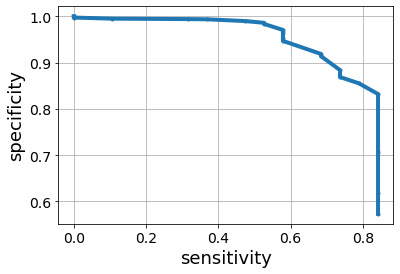

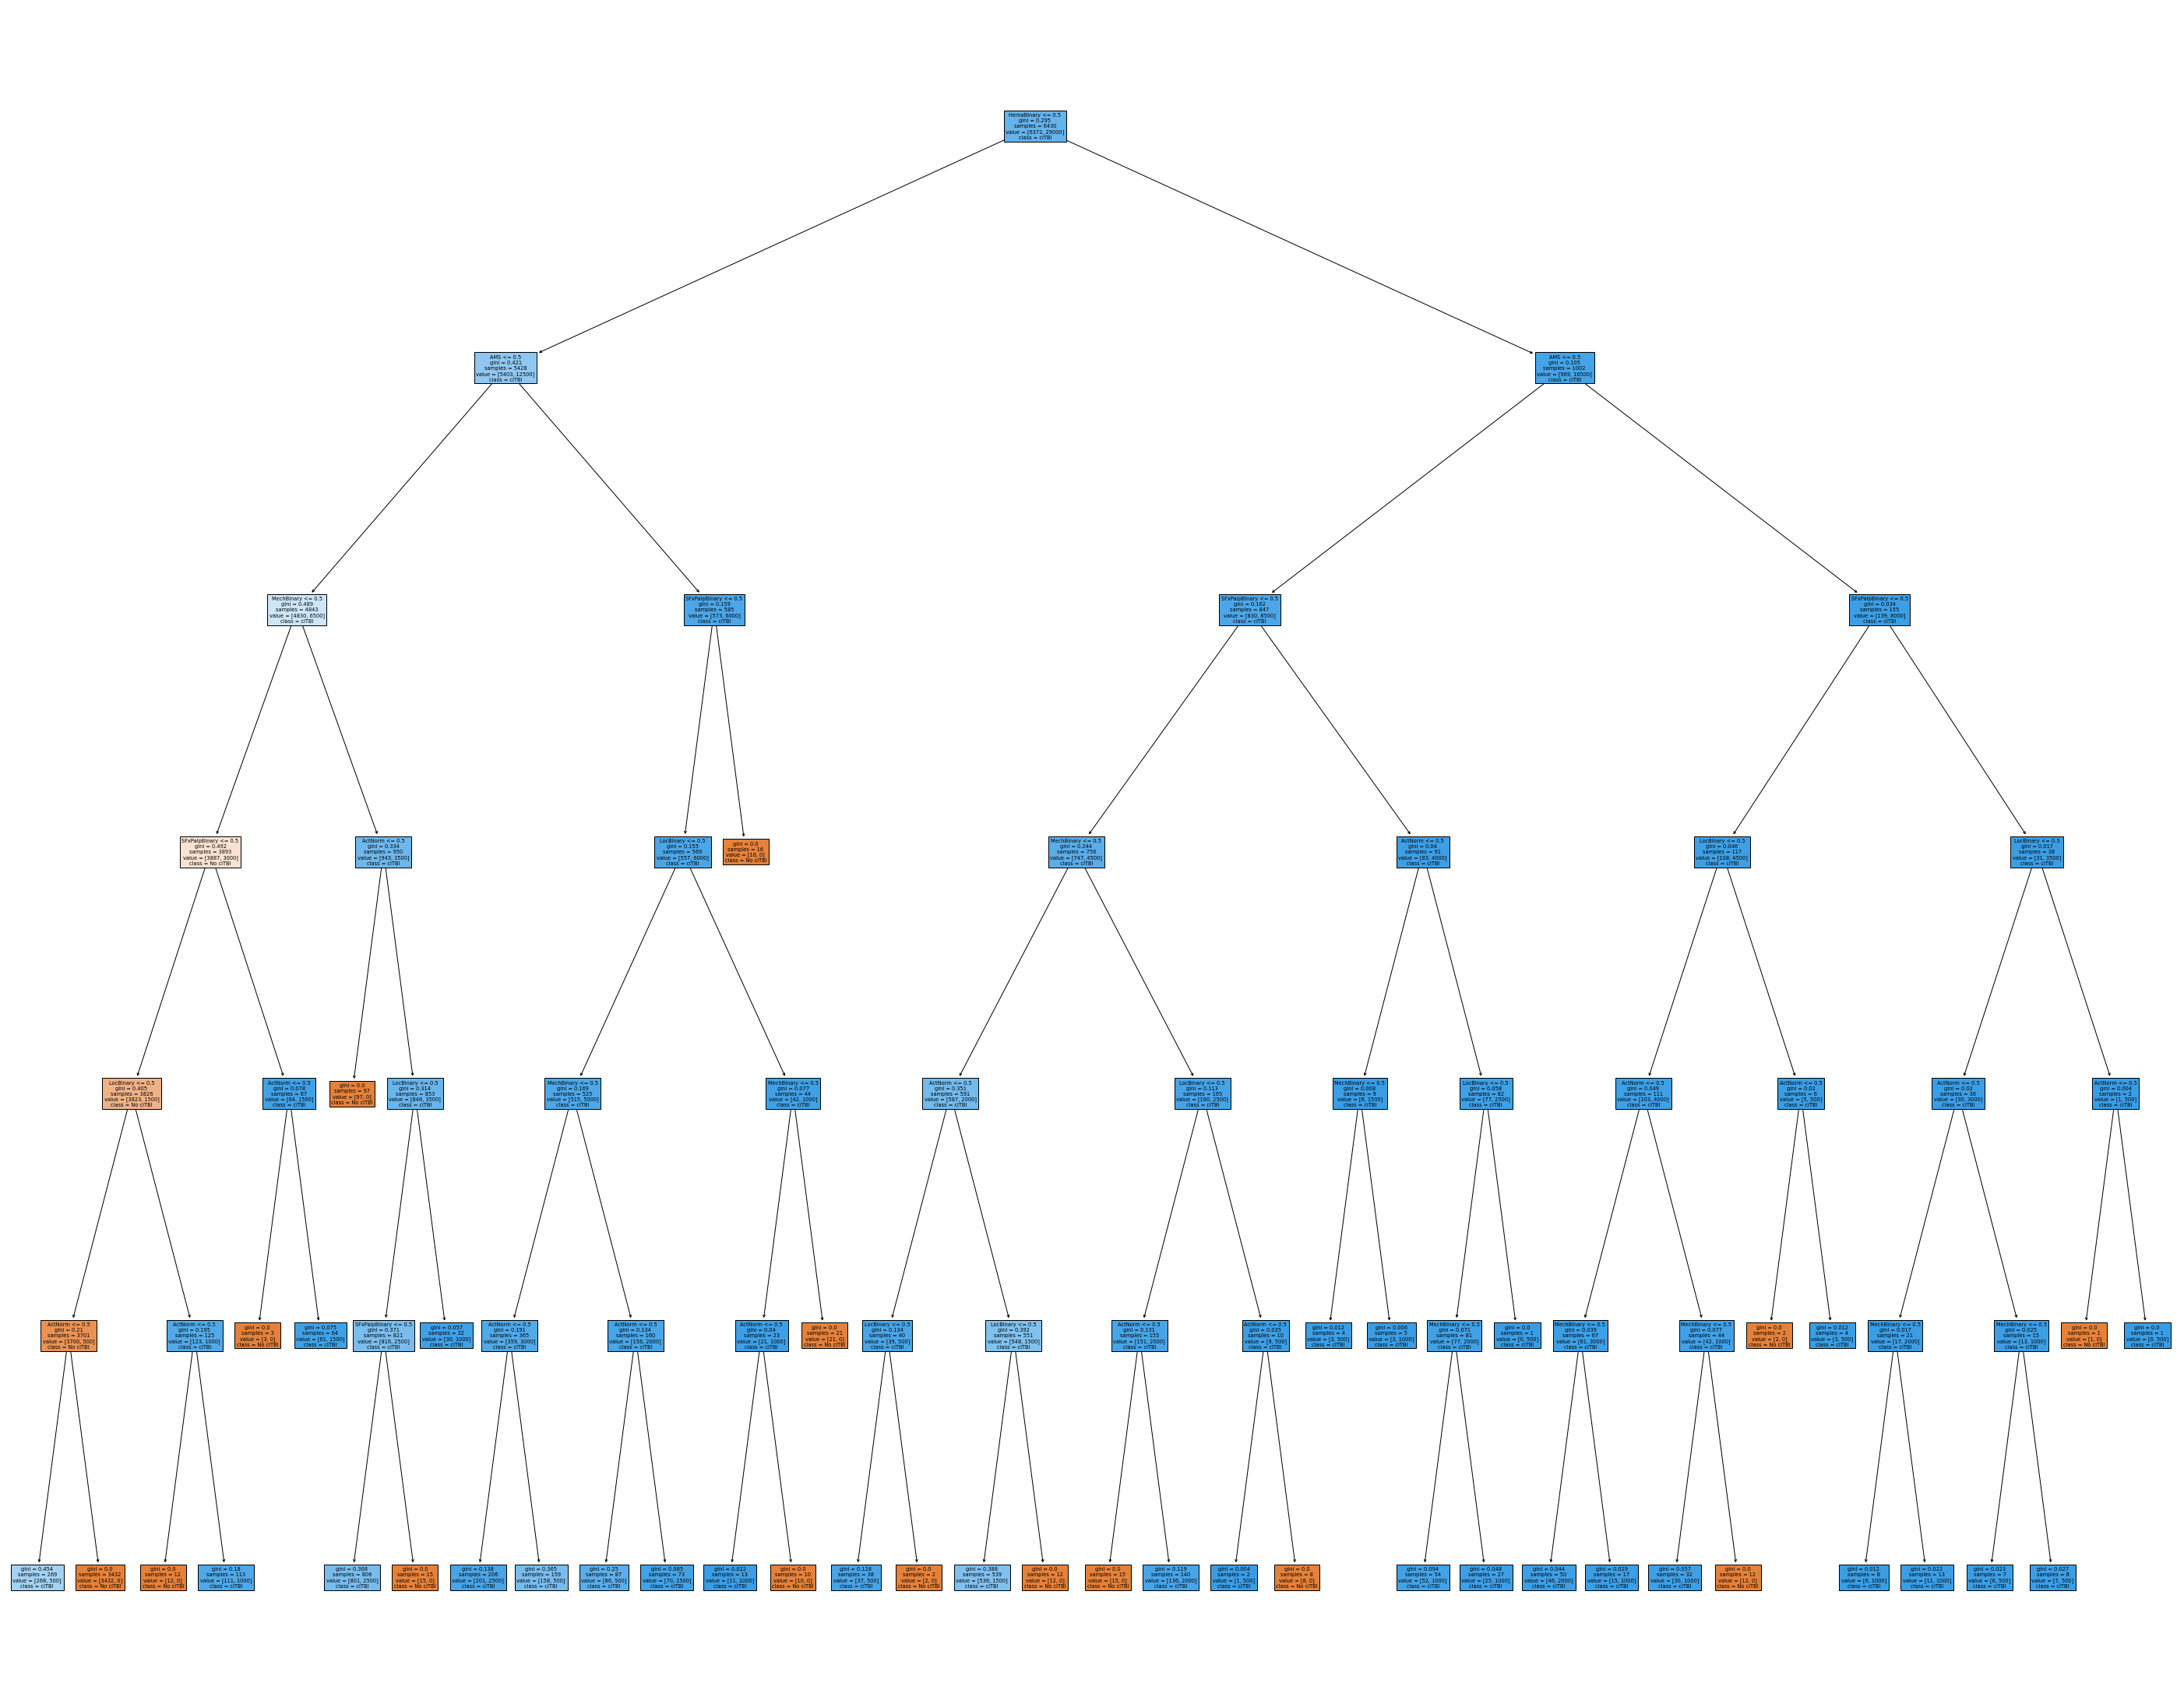

Feature Importances:

SFxPalpBinary     0.201
LocBinary      0.190
HemaBinary     0.177
AMS            0.165
ActNorm        0.135
MechBinary     0.133

Test Score:

0.5755597014925373


In [40]:
# looking at the young decision tree - first with equal weights and same depth
outcome_def = 'PosIntFinal'
X_train = df_young_train.drop(columns=outcome_def)
y_train = df_young_train[outcome_def].values
X_tune = df_young_test.drop(columns=outcome_def)
y_tune = df_young_test[outcome_def].values
feature_names = list(X_train)

def predict_and_save(model, model_name='decision_tree'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_tune],
                            [y_train, y_tune],
                            ['_train', '_tune']):
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x)[:, 1],
                                                     plot=suffix == '_tune')
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
    return stats, threshes

# fitting the model 
dt = DecisionTreeClassifier(max_depth=6, class_weight={0: 1, 1: 500})
dt.fit(X_train, y_train)
stats, threshes = predict_and_save(dt, model_name='decision_tree')
plt.show()

fig = plt.figure(figsize=(50, 40))
plot_tree(dt, feature_names=feature_names, class_names = ['No ciTBI', 'ciTBI'], filled=True)
plt.show()

print('Feature Importances:\n')
for col, val in sorted(zip(X_train.columns, dt.feature_importances_), key=lambda x: x[1], reverse=True)[:10]:
    print(f'{col:10}{val:10.3f}')
    
print('\nTest Score:\n')
print(dt.score(X_tune, y_tune))

In [41]:
# different way to view the tree that's a bit easier with more depth
print(export_text(dt, feature_names = feature_names))

|--- HemaBinary <= 0.50
|   |--- AMS <= 0.50
|   |   |--- MechBinary <= 0.50
|   |   |   |--- SFxPalpBinary <= 0.50
|   |   |   |   |--- LocBinary <= 0.50
|   |   |   |   |   |--- ActNorm <= 0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- ActNorm >  0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- LocBinary >  0.50
|   |   |   |   |   |--- ActNorm <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- ActNorm >  0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- SFxPalpBinary >  0.50
|   |   |   |   |--- ActNorm <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- ActNorm >  0.50
|   |   |   |   |   |--- class: 1
|   |   |--- MechBinary >  0.50
|   |   |   |--- ActNorm <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- ActNorm >  0.50
|   |   |   |   |--- LocBinary <= 0.50
|   |   |   |   |   |--- SFxPalpBinary <= 0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- SFxPalpBinary >  0.50
|   |   | 

Now we can traverse through the tree to obtain the probabilities for each of our groupings.

In [42]:
from sklearn.tree import _tree

def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [feature_names[i] if i != _tree.TREE_UNDEFINED 
                    else "Undefined!" for i in tree_.feature]
    paths = []
    path = []
    
    def recurse(node, path, paths):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)    
    samples_count = [p[-1][1] for p in paths]
    sorted_samples = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(sorted_samples)]
    rules = []
    for path in paths:
        rule = "if "
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
            rule += '\n'
            
        rule += " then\n"
        if class_names is None:
            rule += "response: " + str(np.round(path[-1][0][0][0], 3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"\t class: {class_names[l]} (prob: {np.round(100 * classes[l] / np.sum(classes), 2)}%)"
        rule += f" | {path[-1][1]:,} samples\n\n"
        rules += [rule]
        
    return rules

rules = get_rules(dt, feature_names, ['No ciTBI', 'ciTBI'])
for rule in rules:
    print(rule)

if (HemaBinary <= 0.5)
 and (AMS <= 0.5)
 and (MechBinary <= 0.5)
 and (SFxPalpBinary <= 0.5)
 and (LocBinary <= 0.5)
 and (ActNorm > 0.5)
 then
	 class: No ciTBI (prob: 100.0%) | 3,432 samples


if (HemaBinary <= 0.5)
 and (AMS <= 0.5)
 and (MechBinary > 0.5)
 and (ActNorm > 0.5)
 and (LocBinary <= 0.5)
 and (SFxPalpBinary <= 0.5)
 then
	 class: ciTBI (prob: 75.73%) | 806 samples


if (HemaBinary > 0.5)
 and (AMS <= 0.5)
 and (SFxPalpBinary <= 0.5)
 and (MechBinary <= 0.5)
 and (ActNorm > 0.5)
 and (LocBinary <= 0.5)
 then
	 class: ciTBI (prob: 73.67%) | 539 samples


if (HemaBinary <= 0.5)
 and (AMS <= 0.5)
 and (MechBinary <= 0.5)
 and (SFxPalpBinary <= 0.5)
 and (LocBinary <= 0.5)
 and (ActNorm <= 0.5)
 then
	 class: ciTBI (prob: 65.1%) | 269 samples


if (HemaBinary <= 0.5)
 and (AMS > 0.5)
 and (SFxPalpBinary <= 0.5)
 and (LocBinary <= 0.5)
 and (MechBinary <= 0.5)
 and (ActNorm <= 0.5)
 then
	 class: ciTBI (prob: 92.56%) | 206 samples


if (HemaBinary <= 0.5)
 and (AMS > 0.5)
 a

There are a few other options we could employ for determining the baseline model. Notably, we could either 1) use their percentages for the rules despite the datasets not matching up or 2) we could assume their rule is best for our data and compute those probabilities. This latter option is relatively reasonable, and so an alternative for our baseline would to follow the same order of the features they choose down to the nodes. Concretely, for <2 year old kids, we would examine AMS (y/n), then HemaBinary (y/n), ...., ActNorm (y/n). 

In [56]:
def get_probs(data, feats):
    # feats must be binary
    # output is dict of prob of ciTBI for each feat
    outcome = 'PosIntFinal'
    probs = []
    probs.append({f'Total': np.round(100 * len(data[data[outcome] == 1]) / len(data), 2)})
    for feat in feats:
        feat_no_count = len(data[data[feat] == 0])
        feat_yes_count = len(data) - feat_no_count
        outcome_no_count = len(data[(data[feat] == 0) & data[outcome] == 1])
        outcome_yes_count = len(data[(data[feat] == 1) & data[outcome] == 1])
        feat_dict = {f'{feat}_No': np.round(100 * outcome_no_count / feat_no_count, 2), 
                    f'{feat}_Yes': np.round(100 * outcome_yes_count / feat_yes_count, 2)}
        probs.append(feat_dict)
        data = data[data[feat] != 1]
        
    return probs

data1 = df_young.copy()
print('Young Kid Probabilities:')
young_rules = get_probs(data1, young_feats)
print(young_rules)
print('\n')
data2 = df_old.copy()
print('Old Kid Probabilities:')
old_rules = get_probs(data2, old_feats)
print(old_rules)

Young Kid Probabilities:
[{'Total': 0.91}, {'AMS_No': 0.5, 'AMS_Yes': 4.13}, {'HemaBinary_No': 0.25, 'HemaBinary_Yes': 1.95}, {'LocBinary_No': 0.19, 'LocBinary_Yes': 1.98}, {'MechBinary_No': 0.13, 'MechBinary_Yes': 0.46}, {'SFxPalpBinary_No': 0.05, 'SFxPalpBinary_Yes': 4.81}, {'ActNorm_No': 0.44, 'ActNorm_Yes': 0.02}]


Old Kid Probabilities:
[{'Total': 0.88}, {'AMS_No': 0.38, 'AMS_Yes': 4.07}, {'LocSeparateBinary_No': 0.23, 'LocSeparateBinary_Yes': 1.17}, {'Vomit_No': 0.16, 'Vomit_Yes': 0.93}, {'MechBinary_No': 0.11, 'MechBinary_Yes': 0.54}, {'SFxPalpBinary_No': 0.09, 'SFxPalpBinary_Yes': 0.86}, {'HABinary_No': 0.08, 'HABinary_Yes': 0.94}]


If we desire to keep the percentages exactly the same as the paper, below I store those as well if we want...

In [57]:
paper_young_rules = [{'Total': 0.9},
                     {'AMS_No': 0.5, 'AMS_Yes': 4.0},
                     {'HemaBinary_No': 0.3, 'HemaBinary_Yes': 1.6},
                     {'LocBinary_No': 0.2, 'LocBinary_Yes': 1.6},
                     {'MechBinary_No': 0.1, 'MechBinary_Yes': 0.5},
                     {'SFxPalpBinary_No': 0.1, 'SFxPalpBinary_Yes': 3.6},
                     {'ActNorm_No': 0.6, 'ActNorm_Yes': 0.02}]

paper_old_rules = [{'Total': 0.9},
                   {'AMS_No': 0.4, 'AMS_Yes': 3.9},
                   {'LocSeparateBinary_No': 0.2, 'LocSeparateBinary_Yes': 1.1},
                   {'Vomit_No': 0.1, 'Vomit_Yes': 1.1},
                   {'MechBinary_No': 0.1, 'MechBinary_Yes': 0.6},
                   {'SFxPalpBinary_No': 0.1, 'SFxPalpBinary_Yes': 7.5}, 
                   {'HABinary_No': 0.001, 'HABinary_Yes': 0.94}]